# Assignment-4 Deep Learning AI2100

## Name-Gunjit Mittal     Roll No.-AI21BTECH11011

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

## Autoencoder

In [3]:
# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, input_dim),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [4]:
# Training the models
input_dim = 28 * 28
hidden_dims = [32, 64]
models = []

for hidden_dim in hidden_dims:
    model = Autoencoder(input_dim, hidden_dim)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    # Train the model
    for epoch in range(10):
        for i, (images, _) in enumerate(train_loader):
            images = Variable(images.view(-1, input_dim))
            outputs = model(images)
            loss = criterion(outputs, images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    models.append(model)

In [5]:
def calculate_reconstruction_error(dataloader, model):
    total_loss = 0
    total_samples = 0

    for images, _ in dataloader:
        images = Variable(images.view(-1, input_dim))
        outputs = model(images)
        loss = criterion(outputs, images)

        total_loss += loss.item() 
        total_samples += 1

    return total_loss / total_samples

for i, model in enumerate(models):
    train_error = calculate_reconstruction_error(train_loader, model)
    test_error = calculate_reconstruction_error(test_loader, model)
    print(f"Model {i + 1} (hidden_dim={hidden_dims[i]}): Train error={train_error}, Test error={test_error}")

Model 1 (hidden_dim=32): Train error=0.015622427565976977, Test error=0.015277001354843379
Model 2 (hidden_dim=64): Train error=0.008359270254150033, Test error=0.008180450582876801


Model 1 (hidden_dim=32): Train data reconstructions


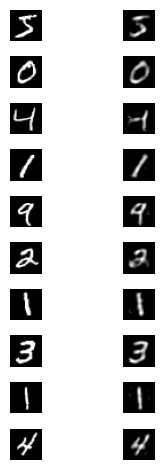

Model 1 (hidden_dim=32): Test data reconstructions


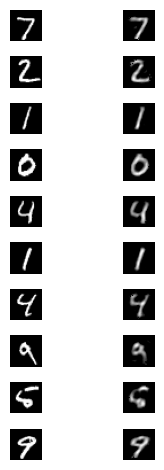

Model 2 (hidden_dim=64): Train data reconstructions


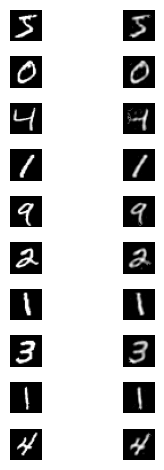

Model 2 (hidden_dim=64): Test data reconstructions


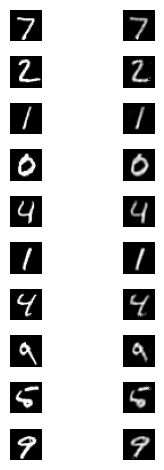

In [6]:
def display_reconstructions(dataloader, model, num_images=10):
    for i in range(num_images):
        original_image = dataloader.dataset[i][0].view(-1, input_dim)
        reconstructed_image = model(original_image)
        plt.subplot(10, 2, 2*i+1)
        plt.axis('off')
        plt.imshow(original_image.view(28, 28), cmap='gray')
        plt.subplot(10, 2, 2*i+2)
        plt.axis('off')
        plt.imshow(reconstructed_image.detach().view(28, 28), cmap='gray')
        plt.tight_layout()
    plt.tight_layout()
    plt.show()

for i, model in enumerate(models):
    print(f"Model {i + 1} (hidden_dim={hidden_dims[i]}): Train data reconstructions")
    display_reconstructions(train_loader, model)

    print(f"Model {i + 1} (hidden_dim={hidden_dims[i]}): Test data reconstructions")
    display_reconstructions(test_loader, model)


Model 1 (hidden_dim=32): Interpolated reconstructions


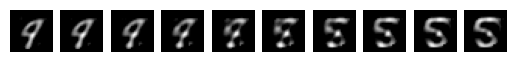

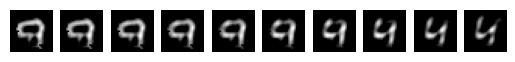

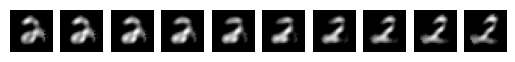

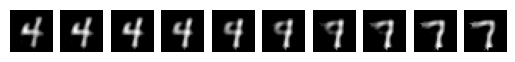

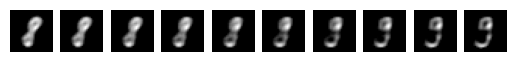

Model 2 (hidden_dim=64): Interpolated reconstructions


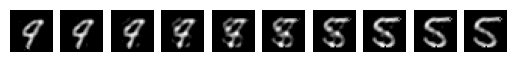

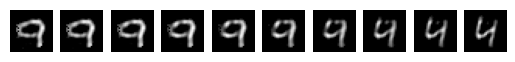

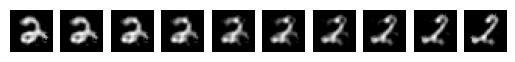

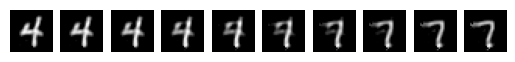

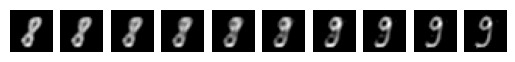

In [7]:
def interpolate_hidden_space(model, sample1, sample2, num_steps=10):
    encoded_sample1 = model.encoder(sample1.view(-1, input_dim))
    encoded_sample2 = model.encoder(sample2.view(-1, input_dim))

    interpolated_hidden_space = []
    for alpha in np.linspace(0, 1, num_steps):
        interpolated_sample = alpha * encoded_sample1 + (1 - alpha) * encoded_sample2
        interpolated_hidden_space.append(interpolated_sample)

    return torch.stack(interpolated_hidden_space)

def display_interpolated_reconstructions(model, sample1, sample2, num_steps=10):
    interpolated_hidden_space = interpolate_hidden_space(model, sample1, sample2, num_steps)
    decoded_samples = model.decoder(interpolated_hidden_space).detach()

    for i in range(num_steps):
        plt.subplot(1, num_steps, i + 1)
        plt.imshow(decoded_samples[i].view(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

# Select 5 random pairs of training data samples
num_pairs = 5
pairs = []
for i in range(num_pairs):
    idx1, idx2 = np.random.randint(0, len(train_dataset), 2)
    sample1, _ = train_dataset[idx1]
    sample2, _ = train_dataset[idx2]
    pairs.append((sample1, sample2))

# Perform the reconstruction on the line joining two training data samples in the hidden space
for i, model in enumerate(models):
    print(f"Model {i + 1} (hidden_dim={hidden_dims[i]}): Interpolated reconstructions")
    for j, (sample1, sample2) in enumerate(pairs):
        display_interpolated_reconstructions(model, sample1, sample2)

## VAE

In [8]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=16):
        super(VAE, self).__init__()
        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var)    
        z = mean + var*epsilon
        return z
    def decode(self, x):
        return self.decoder(x)
    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, log_var)
        x_hat = self.decode(z)
        return x_hat, mean, log_var


In [9]:
# Loss for VAE
def loss_function(x_hat, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(
        x_hat, x.view(-1, 784), reduction='sum'
    )
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))
    return BCE + KLD

# Train VAE
def train_vae(model, dataloader, epochs=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(dataloader):
            data = data.view(data.size(0), -1)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            optimizer.step()
    return model

vae = VAE()
vae = train_vae(vae, train_loader)


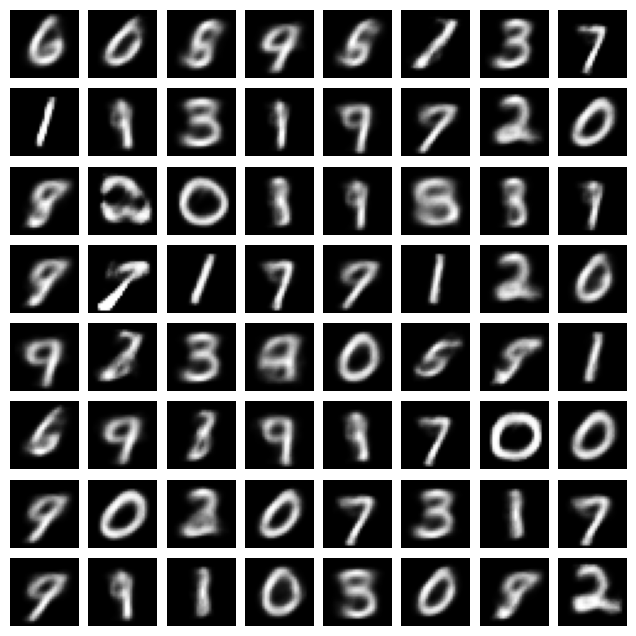

In [10]:
# Generate images from VAE
def generate_images(model, num_images=64):
    with torch.no_grad():
        z = torch.randn(num_images, 2)
        samples = model.decode(z)
        samples = samples.view(num_images, 28, 28)
        
        fig = plt.figure(figsize=(8, 8))
        grid = ImageGrid(fig, 111, nrows_ncols=(8, 8), axes_pad=0.1)
        for ax, im in zip(grid, samples):
            ax.imshow(im, cmap='gray')
            ax.axis('off')
        plt.show()

generate_images(vae, 64)


## Self attention

In [11]:
class SelfAttention(nn.Module):
    "Self attention layer for `n_channels`."
    def __init__(self, n_channels):
        super(SelfAttention, self).__init__()
        self.query,self.key,self.value = [self._conv(n_channels, c) for c in (n_channels//8,n_channels//8,n_channels)]
        self.gamma = nn.Parameter(torch.tensor([0.]))

    def _conv(self,n_in,n_out):
        return nn.Conv1d(n_in, n_out, kernel_size=1, bias=False)

    def forward(self, x):
        size = x.size()
        x = x.view(*size[:2],-1)
        f,g,h = self.query(x),self.key(x),self.value(x)
        beta = F.softmax(torch.bmm(f.transpose(1,2), g), dim=1)
        o = self.gamma * torch.bmm(h, beta) + x
        return o.view(*size).contiguous()

In [12]:
class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super(CIFAR10_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.attention1 = SelfAttention(32)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.attention1(x)
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

model = CIFAR10_CNN()

In [13]:
# Data preprocessing and augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=200, shuffle=False, num_workers=2)

In [16]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs, labels
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Testing
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        epoch_loss = 0
        for inputs, labels in test_loader:
            inputs, labels = inputs, labels
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            loss = criterion(outputs, labels)
            epoch_loss += loss.sum().item()
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / total}")

Epoch [1/10], Loss: 0.00992482419013977
Epoch [2/10], Loss: 0.009587925815582276
Epoch [3/10], Loss: 0.009323415124416352
Epoch [4/10], Loss: 0.009125213527679444
Epoch [5/10], Loss: 0.008942786431312561
Epoch [6/10], Loss: 0.008733052384853363
Epoch [7/10], Loss: 0.008652067279815674
Epoch [8/10], Loss: 0.008557902228832246
Epoch [9/10], Loss: 0.008488424444198608
Epoch [10/10], Loss: 0.008393165552616119
